In [44]:
from multiprocessing import Pool
import os
from inspect import signature
import re
import string
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve,
                             average_precision_score)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline

sys.path.append("../src")
import constants as c
from utils import *

import warnings 
  
warnings.filterwarnings(action = 'ignore') 
  
import gensim 
from gensim.models import Word2Vec 

In [7]:
plt.rcParams["figure.figsize"] = (20,10)

---

In [8]:
train_df = load_data('train.csv')
test_df = load_data('test.csv') 
sample_submission_df = load_data('sample_submission.csv') 

# Data

We're provided with 3 files. Train and test csv files and a submission example file. The submission file is very simple, it includes 2 columns, one of a target ID, and one for the target prediction. The train/test datasets consist of 5 columns: an **id**, a **keyword** column that describes the type of disaster, a **location** of the tweet, the **text** body of the tweet, and finally, a **target** classifying it as real (target=1), or not (target=0). The training and test sets constain 7613 and 3263 examples, respectively.

In [9]:
os.listdir(c.data_dir)

['sample_submission.csv', 'test.csv', 'train.csv']

In [10]:
sample_submission_df.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [19]:
print(f"train examples: {train_df.shape[0]}, test examples: {test_df.shape[0]}")

train examples: 7613, test examples: 3263


In [7]:
display(train_df.head())
display(test_df.head())

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### The datasets are slighly imbalanced as the training set contains slightly more fake tweet examples (4362 vs 3271)

'# Real Tweets: 3271'

'# Fake Tweets: 4342'

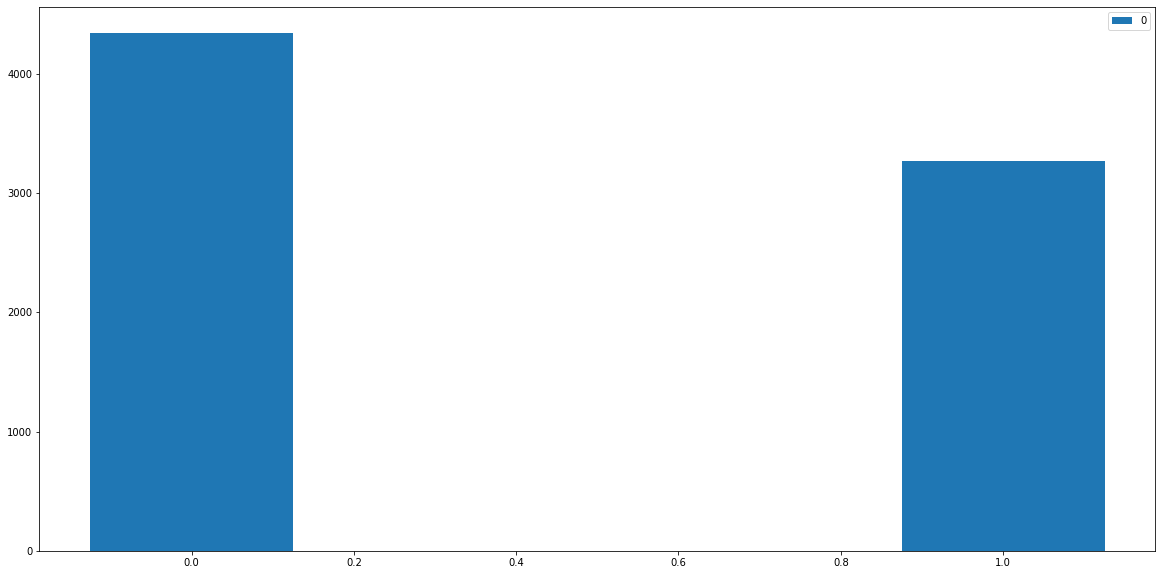

In [8]:
display("# Real Tweets: " + str(train_df[train_df["target"] == 1].shape[0]))
display("# Fake Tweets: " + str(train_df[train_df["target"] == 0].shape[0]))
plt.bar([0, 1], [train_df[train_df["target"] == 0].shape[0], train_df[train_df["target"] == 1].shape[0]], 0.25)
plt.legend(("0", "1"))

### Distribution of length of tweets

The mean length is slightly lower in real tweets, and in both real and not real disaster tweets, is very skewed twowards smaller tweets

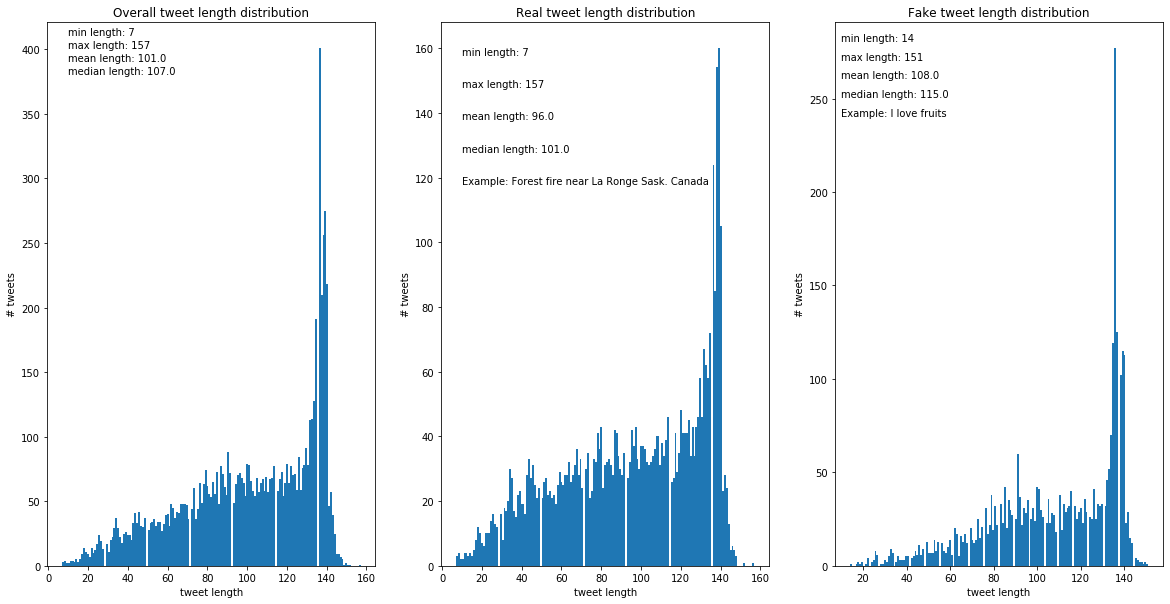

In [9]:
plot_tweet_distribution(train_df)

In [27]:
from wordcloud import WordCloud

In [40]:
def word_cloud(corpus):

    words = ' '.join(corpus)
    words_wc = WordCloud(width=512, height=512).generate(words)
    plt.figure(figsize=(10, 8), facecolor="k")
    plt.imshow(words_wc)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

In [36]:
train_df[train_df.target == 0].iloc[0]["text"]

"What's up man?"

In [34]:
corpus = train_df[(train_df["keyword"].isna() == False) & (train_df["target"] == 1) ]["keyword"].values

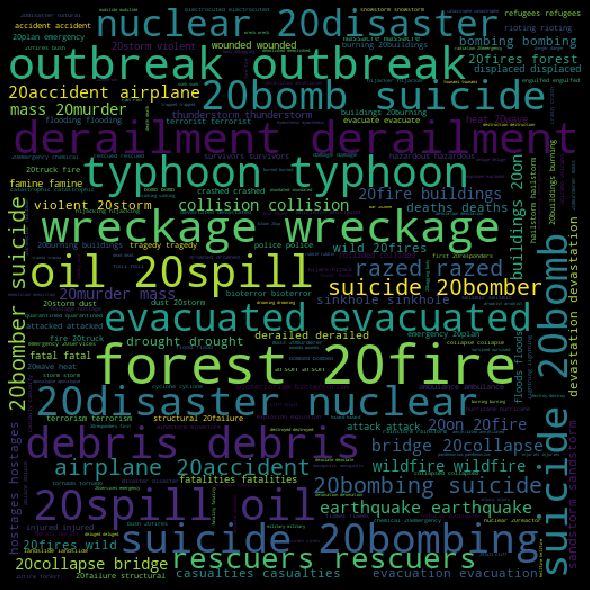

In [41]:
word_cloud(corpus)

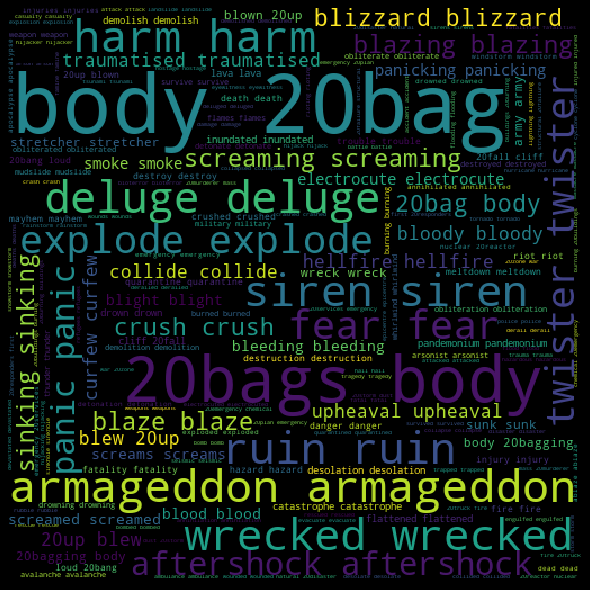

In [19]:
word_cloud(train_df[train_df["keyword"].isna() == False], 0, "keyword")

In [699]:
display(train_df[train_df["keyword"].isna() == False]['keyword'].unique().shape)
display(train_df[train_df["keyword"].isna() == False]['keyword'].unique())

(221,)

array(['ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'derailed

In [701]:
display(train_df[train_df["location"].isna() == False]['location'].unique().shape)
display(train_df[train_df["location"].isna() == False]['location'].unique())

(3341,)

array(['Birmingham', 'Est. September 2012 - Bristol', 'AFRICA', ...,
       'Vancouver, Canada', 'London ', 'Lincoln'], dtype=object)

In [704]:
display(train_df[train_df["keyword"].isna()].shape)

(61, 5)

In [705]:
display(train_df[train_df["location"].isna()].shape)

(2533, 5)

In [709]:
train_df[train_df["target"] == 0]["text"].values[2]

'Summer is lovely'

In [710]:
train_df[train_df["target"] == 1]["text"].values[2]

"All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"

In [713]:
def parallelize_dataframe(df, func, n_cores=4):
    """parallelize the work done by the apply function
    """
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

# Naive bayes with Bag or words

We must feed numeric data to our model, not text data. The text messages can be represented in different ways. The simplest is a bag of words, which is a frequency of the word (# of occurrences of word in dataset / total # words in dataset). Later we'll use TF-IDF representations, as well as word embeddings.

In [740]:
count_vectorizer = feature_extraction.text.CountVectorizer(stop_words='english', lowercase=True)

In [742]:
train_vectors = count_vectorizer.fit_transform(train_df["text"])

In [746]:
train_vectors[:5].todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [14]:
from wordcloud import WordCloud

In [17]:
def word_cloud(df, target=1, column="text"):

    words = ' '.join(df[df.target == target][column])
    words_wc = WordCloud(width=512, height=512).generate(words)
    plt.figure(figsize=(10, 8), facecolor="k")
    plt.imshow(words_wc)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

In [757]:
def plot_confusion_matrix(y_test, predictions):
    labels = [0, 1]
    cm = confusion_matrix(y_test, predictions, labels)
    print(cm)
    labels = ["real", "not"]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [20]:
word_cloud(train_df, 0)

NameError: name 'word_cloud' is not defined

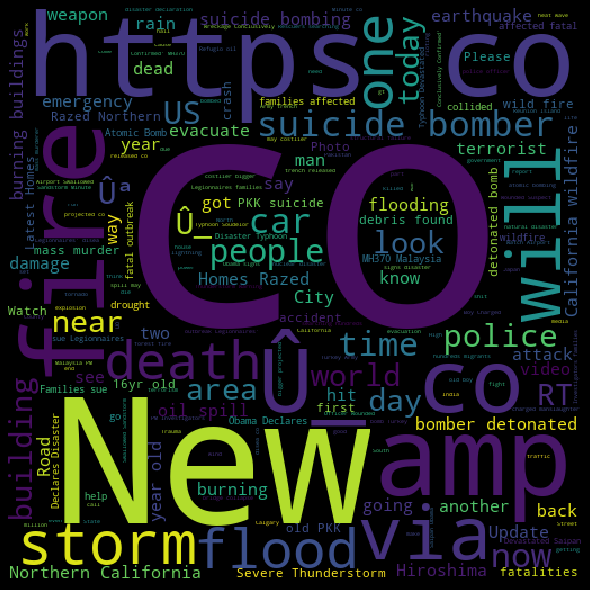

In [721]:
word_cloud(train_df, 1)

In [737]:
X_train, X_test, y_train, y_test = train_test_split(train_df["text"],
                                                    train_df["target"],
                                                    random_state=1)

In [738]:
X_train.shape[0], y_train.shape[0]

(5709, 5709)

In [739]:
X_test.shape[0], y_test.shape[0]

(1904, 1904)

In [797]:
train_data = count_vectorizer.fit_transform(X_train)
test_data = count_vectorizer.transform(X_test)

In [798]:
naive_bayes = BernoulliNB()
naive_bayes.fit(train_data, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [799]:
predictions = naive_bayes.predict(test_data)

In [800]:
print('Accuracy score: ', format(accuracy_score(predictions, y_test )))
print('Precision score: ', format(precision_score(predictions, y_test)))
print('Recall score: ', format(recall_score(predictions, y_test)))
print('F1 score: ', format(f1_score(predictions, y_test)))

Accuracy score:  0.8061974789915967
Precision score:  0.6100861008610086
Recall score:  0.9051094890510949
F1 score:  0.7288758265980896


In [801]:
confusion_matrix(y_test, predictions)

array([[1039,   52],
       [ 317,  496]])

[[1039   52]
 [ 317  496]]


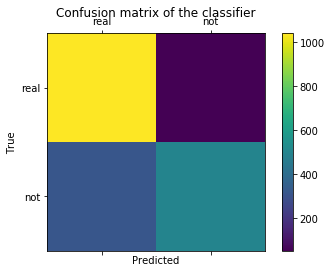

In [802]:
plot_confusion_matrix(y_test, predictions)

In [787]:
fpr, tpr, thresholds = roc_curve(np.array(y_test), predictions, pos_label=1)

In [788]:
roc_auc = auc(fpr, tpr)

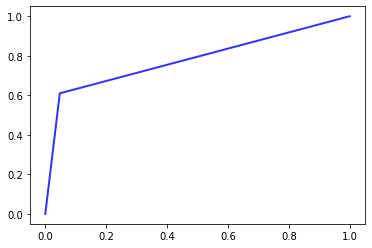

In [789]:
plt.plot(fpr, tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f)' % (roc_auc),
         lw=2, alpha=.8)

In [790]:
precision, recall, _ = precision_recall_curve(y_test, predictions)

In [791]:
print(precision, recall)

[0.4269958  0.90510949 1.        ] [1.        0.6100861 0.       ]


In [792]:
average_precision = average_precision_score(y_test, predictions)

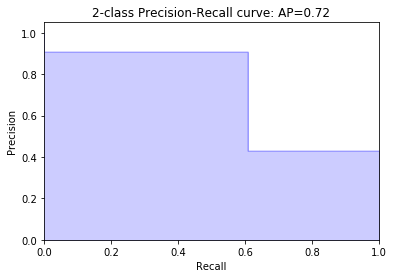

In [793]:
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
print("")

# Naive bayes with TF-IDF

Lets try the same algorithm, but with a different representation of the sentences. We'll use the word importance (TF-IDF) instead of plain word frequency

In [778]:
pipeline = Pipeline([
    ('vect', feature_extraction.text.CountVectorizer(stop_words='english', lowercase=True)),
    ('tfidf', TfidfTransformer(use_idf=True, smooth_idf=True)),
    ('clf', BernoulliNB(alpha=1))
])

In [803]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 BernoulliNB(alpha=1, binarize=0.0, class_prior=None,
                             fit_prior=True))],
         verbose=False)

In [804]:
predictions = pipeline.predict(X_test)

In [805]:
print('Accuracy score: ', format(accuracy_score(predictions, y_test )))
print('Precision score: ', format(precision_score(predictions, y_test)))
print('Recall score: ', format(recall_score(predictions, y_test)))
print('F1 score: ', format(f1_score(predictions, y_test)))

Accuracy score:  0.8061974789915967
Precision score:  0.6100861008610086
Recall score:  0.9051094890510949
F1 score:  0.7288758265980896


# Our very own implementation of naive bayes

In [829]:
class Detector(object):
    """Implementation of Naive Bayes for binary classification"""
    def clean(self, s):
        translator = str.maketrans("", "", string.punctuation)
        return s.translate(translator)

    def tokenize(self, text):
        text = self.clean(text).lower()
        return re.split("\W+", text)

    def get_word_counts(self, words):
        word_counts = {}
        for word in words:
            word_counts[word] = word_counts.get(word, 0.0) + 1.0
        return word_counts
    
    def fit(self, X, Y):
        self.num_messages = {}
        self.log_class_priors = {}
        self.word_counts = {}
        self.vocab = set()

        n = len(X)
        self.num_messages['pos'] = sum(Y)
        self.num_messages['neg'] = len(Y) - self.num_messages['pos']
        self.log_class_priors['pos'] = math.log(self.num_messages['pos'] / n)
        self.log_class_priors['neg'] = math.log(self.num_messages['neg'] / n)
        self.word_counts['pos'] = {}
        self.word_counts['neg'] = {}

        for x, y in zip(X, Y):  # for each document
            c = 'pos' if y == 1 else 'neg'
            counts = self.get_word_counts(self.tokenize(x))
            for word, count in counts.items():  # for each word in the doc
                if word not in self.vocab:
                    self.vocab.add(word)
                if word not in self.word_counts[c]:
                    self.word_counts[c][word] = 0.0

                self.word_counts[c][word] += count
                
    def predict(self, X):
        result = []
        for x in X:
            counts = self.get_word_counts(self.tokenize(x))
            real_score = 0
            not_real_score = 0
            for word, _ in counts.items():
                if word not in self.vocab: continue

                # add Laplace smoothing (add 1 to the word count to handle cases when the word is not present)
                log_w_given_spam = math.log( (self.word_counts['pos'].get(word, 0.0) + 1) / (self.num_messages['pos'] + len(self.vocab)) )
                log_w_given_ham = math.log( (self.word_counts['neg'].get(word, 0.0) + 1) / (self.num_messages['neg'] + len(self.vocab)) )

                real_score += log_w_given_spam
                not_real_score += log_w_given_ham

            real_score += self.log_class_priors['pos']
            not_real_score += self.log_class_priors['neg']

            if real_score > not_real_score:
                result.append(1)
            else:
                result.append(0)
        return result

In [830]:
d = Detector()

In [831]:
d.fit(X_train.tolist(), y_train.tolist())

In [832]:
predictions = d.predict(X_test)

In [833]:
print('Accuracy score: ', format(accuracy_score(predictions, y_test )))
print('Precision score: ', format(precision_score(predictions, y_test)))
print('Recall score: ', format(recall_score(predictions, y_test)))
print('F1 score: ', format(f1_score(predictions, y_test)))

Accuracy score:  0.7888655462184874
Precision score:  0.5940959409594095
Recall score:  0.8702702702702703
F1 score:  0.706140350877193


[[1019   72]
 [ 330  483]]


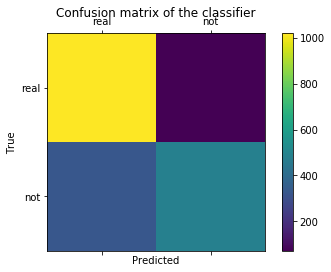

In [834]:
plot_confusion_matrix(y_test, predictions)

# Word embeddings and a neural network

In [842]:
!pip install tensorflow

You should consider upgrading via the 'pip install --upgrade pip' command.


In [843]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# print(tf.__version__)

In [844]:
print(tf.__version__)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/luiscunha/.pyenv/versions/3.7.3/envs/dc-3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-844-65f07e81e169>", line 1, in <module>
    print(tf.__version__)
AttributeError: module 'tensorflow' has no attribute '__version__'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/luiscunha/.pyenv/versions/3.7.3/envs/dc-3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2033, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/luiscunha/.pyenv/versions/3.7.3/envs/dc-3.7.3/lib/python3.7/site-packages/tensorflow_core/python/pywrap_tensorflow.p

AttributeError: module 'tensorflow' has no attribute '__version__'

In [845]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=160000
test_portion=.1

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/luiscunha/.pyenv/versions/3.7.3/envs/dc-3.7.3/lib/python3.7/site-packages/tensorflow_core/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/Users/luiscunha/.pyenv/versions/3.7.3/envs/dc-3.7.3/lib/python3.7/site-packages/tensorflow_core/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/Users/luiscunha/.pyenv/versions/3.7.3/envs/dc-3.7.3/lib/python3.7/site-packages/tensorflow_core/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/Users/luiscunha/.pyenv/versions/3.7.3/lib/python3.7/imp.py", line 242, in load_module
    return load_dynamic(name, filename, file)
  File "/Users/luiscunha/.pyenv/versions/3.7.3/lib/python3.7/imp.py", line 342, in load_dynamic
    return _load(spec)
Import

TypeError: can only concatenate str (not "list") to str

In [846]:
tokenizer = Tokenizer(oov_token="<OOV>")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/luiscunha/.pyenv/versions/3.7.3/envs/dc-3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-846-93c1dd5c791d>", line 1, in <module>
    tokenizer = Tokenizer(oov_token="<OOV>")
NameError: name 'Tokenizer' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/luiscunha/.pyenv/versions/3.7.3/envs/dc-3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2033, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/luiscunha/.pyenv/versions/3.7.3/envs/dc-3.7.3/lib/python3.7/site-packages/tensorflow_core/python/pywrap_tensorflow.py", line 5

NameError: name 'Tokenizer' is not defined

In [847]:
sentences = dataset["body"].tolist()
labels = dataset["spam"].tolist()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/luiscunha/.pyenv/versions/3.7.3/envs/dc-3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-847-654369b18145>", line 1, in <module>
    sentences = dataset["body"].tolist()
NameError: name 'dataset' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/luiscunha/.pyenv/versions/3.7.3/envs/dc-3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2033, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/luiscunha/.pyenv/versions/3.7.3/envs/dc-3.7.3/lib/python3.7/site-packages/tensorflow_core/python/pywrap_tensorflow.py", line 58, in 

NameError: name 'dataset' is not defined

In [848]:
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
print(len(word_index))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/luiscunha/.pyenv/versions/3.7.3/envs/dc-3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-848-ea338915b04e>", line 1, in <module>
    tokenizer.fit_on_texts(sentences)
NameError: name 'tokenizer' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/luiscunha/.pyenv/versions/3.7.3/envs/dc-3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2033, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/luiscunha/.pyenv/versions/3.7.3/envs/dc-3.7.3/lib/python3.7/site-packages/tensorflow_core/python/pywrap_tensorflow.py", line 58, in <

NameError: name 'tokenizer' is not defined

In [849]:
vocab_size=len(word_index)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/luiscunha/.pyenv/versions/3.7.3/envs/dc-3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-849-8a9818e40fdb>", line 1, in <module>
    vocab_size=len(word_index)
NameError: name 'word_index' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/luiscunha/.pyenv/versions/3.7.3/envs/dc-3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2033, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/luiscunha/.pyenv/versions/3.7.3/envs/dc-3.7.3/lib/python3.7/site-packages/tensorflow_core/python/pywrap_tensorflow.py", line 58, in <module

NameError: name 'word_index' is not defined

In [850]:
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/luiscunha/.pyenv/versions/3.7.3/envs/dc-3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-850-785b3e2294bb>", line 1, in <module>
    sequences = tokenizer.texts_to_sequences(sentences)
NameError: name 'tokenizer' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/luiscunha/.pyenv/versions/3.7.3/envs/dc-3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2033, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/luiscunha/.pyenv/versions/3.7.3/envs/dc-3.7.3/lib/python3.7/site-packages/tensorflow_core/python/pywrap_tensorflow.

NameError: name 'tokenizer' is not defined

In [851]:
training_size=len(sequences)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/luiscunha/.pyenv/versions/3.7.3/envs/dc-3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-851-7923139ed7d7>", line 1, in <module>
    training_size=len(sequences)
NameError: name 'sequences' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/luiscunha/.pyenv/versions/3.7.3/envs/dc-3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2033, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/luiscunha/.pyenv/versions/3.7.3/envs/dc-3.7.3/lib/python3.7/site-packages/tensorflow_core/python/pywrap_tensorflow.py", line 58, in <modul

NameError: name 'sequences' is not defined

In [852]:
split = int(test_portion * training_size)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/luiscunha/.pyenv/versions/3.7.3/envs/dc-3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-852-1402c5a48632>", line 1, in <module>
    split = int(test_portion * training_size)
NameError: name 'test_portion' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/luiscunha/.pyenv/versions/3.7.3/envs/dc-3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2033, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/luiscunha/.pyenv/versions/3.7.3/envs/dc-3.7.3/lib/python3.7/site-packages/tensorflow_core/python/pywrap_tensorflow.py", li

NameError: name 'test_portion' is not defined

In [853]:
test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/luiscunha/.pyenv/versions/3.7.3/envs/dc-3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-853-8ec0ccb7efbd>", line 1, in <module>
    test_sequences = padded[0:split]
NameError: name 'padded' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/luiscunha/.pyenv/versions/3.7.3/envs/dc-3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2033, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/luiscunha/.pyenv/versions/3.7.3/envs/dc-3.7.3/lib/python3.7/site-packages/tensorflow_core/python/pywrap_tensorflow.py", line 58, in <modu

NameError: name 'padded' is not defined

In [854]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt

--2020-02-09 20:55:11--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com... 172.217.12.208, 2607:f8b0:4006:81b::2010
Connecting to storage.googleapis.com|172.217.12.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  9.50MB/s    in 32s     

2020-02-09 20:55:43 (10.3 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [855]:
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

In [856]:
embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/luiscunha/.pyenv/versions/3.7.3/envs/dc-3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-856-2497fc05b56a>", line 1, in <module>
    embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
NameError: name 'vocab_size' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/luiscunha/.pyenv/versions/3.7.3/envs/dc-3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2033, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/luiscunha/.pyenv/versions/3.7.3/envs/dc-3.7.3/lib/python3.7/site-packages/tensorflow_core/python/pywrap_t

NameError: name 'vocab_size' is not defined

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 50
history = model.fit(training_sequences, np.array(training_labels), epochs=num_epochs, validation_data=(test_sequences, np.array(test_labels)), verbose=2)

print("Training Complete")

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

In [ ]:
history.history.keys()

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

In [ ]:
np.array([training_sequences[0]]).shape

In [ ]:
model.predict(np.array([training_sequences[i] for i in range(10)]))

# BERT

- https://www.kaggle.com/xwalker/bert-classifier
- https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub

In [ ]:
https://www.kaggle.com/mehulkumar99/disaster-tweets-minimal-word-level-vanilla-rnn

In [ ]:
http://neuralnetworksanddeeplearning.com/chap6.html